In [2]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me']


In [3]:
for idx, sentence in enumerate(raw_corpus):
    # 길이가 0이면 패스
    if len(sentence) == 0: continue
    # 문장의 끝이 :이면 패스
    if sentence[-1] == ":": continue 
    #10개 문장만 먼저 보겠습니다.
    if idx >9: break 
        
    print(sentence)

[Hook]
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face [Verse 1]
Somethin' ain't right when we talkin'


In [4]:
import re    
import numpy as np         
import tensorflow as tf    

def preprocess_sentence(sentence):
    #일단 모두 소문자로 변환하고 양쪽 공백을 지웁니다.
    sentence = sentence.lower().strip()   
    # 아래 특수문자 기호 양쪽에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
     # 공백이 많을 수 있는 부분에는 하나의 공백으로 통일합니다.
    sentence = re.sub(r'[" "]+', " ", sentence) 
     # ""안에 들어가있는 기호들 외에 공백으로 바꿉니다.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    #다시 양쪽 공백을 지웁니다.
    sentence = sentence.strip()
    # 문장 시작과 끝에 start와 end 를 추가합니다.
    sentence = '<start> ' + sentence + ' <end>'      
    
    return sentence

# 아래 같이 결측치 투성이인 문장이 어떻게 변하는지 확인합니다.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

<start> this is sample sentence . <end>


['<start> hook <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face verse <end>',
 '<start> somethin ain t right when we talkin <end>']

In [5]:
def tokenize(corpus):
    # 텐서플로의 토크마이저를 이용해서 7000개 단어 개수를 숫자로 바꿔줍니다.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  
        filters=' ',   
        oov_token="<unk>" 
    )
    #위에서 만든 문장을 토크마이저에 넣어 데이터를 구축합니다.
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus) 
	
    #문장의 길이를 맞추고 숫자로 반환하기 위해 작업을 합니다.
    # 문장의 길이는 가장 긴 문장을 기준으로 pandding합니다.
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = 50
    maxlen = int(max_tokens)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)
print(len(tensor))
print(len(corpus))

[[   2  953    3 ...    0    0    0]
 [   2    5   91 ...    0    0    0]
 [   2   45  134 ...    0    0    0]
 ...
 [   2  211    3 ...    0    0    0]
 [   2  399    9 ...    0    0    0]
 [   2    9 1294 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fd4b84fff90>
175749
175749


In [18]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx > 20: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : t
16 : s
17 : that
18 : on
19 : of
20 : .
21 : your


# spilt data

In [6]:
#마지막 토큰을 잘라냅니다. 위에서 end라고 설정했지만 문장 길이 상 pad인 것이 많을 것입니다.
src_input = tensor[:, :-1]
#앞에 start부분을 자릅니다. 
tgt_input = tensor[:, 1:]
print(src_input[0])
print(tgt_input[0])

[  2 953   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
[953   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [8]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2)

In [9]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (140599, 49)
Target Train: (140599, 49)


In [10]:
BUFFER_SIZE = len(src_input)
print(BUFFER_SIZE)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1  # 사전에 포함되지 않은 0:<pad>를 더해줍니다.

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

175749


<BatchDataset shapes: ((256, 49), (256, 49)), types: (tf.int32, tf.int32)>

In [15]:
BUFFER_SIZE = len(src_input)
print(BUFFER_SIZE)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1  # 사전에 포함되지 않은 0:<pad>를 더해줍니다.

test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, enc_val)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset

175749


<BatchDataset shapes: ((256, 49), (256, 49)), types: (tf.int32, tf.int32)>

In [11]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
            
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024

#여기서 tokenizer.num_words + 1를 했는데 그 이유는 문장에 없는 pad 가 넣어졌기 때문입니다.
#문장길이를 모두 통일 하기 위해 가장 긴문장 말고는 모든 토큰이 0으로 들어간 부분 때문입니다.
model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

In [13]:
for src_sample, tgt_sample in train_dataset.take(1): 
    break
model(src_sample)
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = tf.keras.optimizers.Adam()        
loss = tf.keras.losses.SparseCategoricalCrossentropy(             
    from_logits=True,             
    reduction='none'        
)        

model.compile(loss=loss, optimizer=optimizer)     
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
549/549 [==============================] - 592s 1s/step - loss: 1.6419 - val_loss: 1.6793
Epoch 2/10
549/549 [==============================] - 586s 1s/step - loss: 1.0124 - val_loss: 1.7896
Epoch 3/10
549/549 [==============================] - 627s 1s/step - loss: 0.9543 - val_loss: 1.8343
Epoch 4/10
549/549 [==============================] - 584s 1s/step - loss: 0.9079 - val_loss: 1.8750
Epoch 5/10
549/549 [==============================] - 584s 1s/step - loss: 0.8709 - val_loss: 1.8838
Epoch 6/10
549/549 [==============================] - 589s 1s/step - loss: 0.8379 - val_loss: 1.9122
Epoch 7/10
549/549 [==============================] - 600s 1s/step - loss: 0.8062 - val_loss: 1.9313
Epoch 8/10
549/549 [==============================] - 578s 1s/step - loss: 0.7764 - val_loss: 1.9518
Epoch 9/10
549/549 [==============================] - 583s 1s/step - loss: 0.7454 - val_loss: 1.9750
Epoch 10/10
549/549 [==============================] - 579s 1s/step - loss: 0.7185 - val_lo

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   
        # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 
        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [18]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you , i love you <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> baby", max_len=20)

'<start> baby , you re the only one <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> I don't want a lot", max_len=20)

'<start> i <unk> want a lot of people in the back <end> '

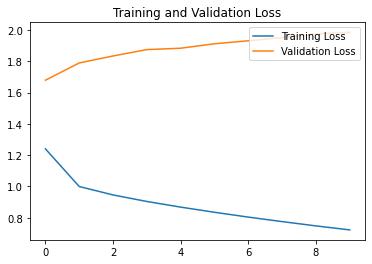

In [21]:
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(loss))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()